In [ ]:
!git clone https://github.com/cvg/LightGlue.git 
!python -m pip install -e LightGlue/

In [ ]:
!pip install gdown


In [58]:
import gdown

# URL of the Google Drive folder
url = 'https://drive.google.com/drive/folders/1lmnSwV1a57_K-AZ7L2C2qbWDZVy6nXhT'
gdown.download_folder(url, quiet=False)


Retrieving folder contents


Processing file 1l8g-BGa_bpgrk4dHvJvMQN5bDH1_8g90 pic1.jpg
Processing file 1z0o-eJ-nQUQDFXBQRyBvEIfwAdFJMJSA pic2.jpg


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1l8g-BGa_bpgrk4dHvJvMQN5bDH1_8g90
To: /kaggle/working/pic_s_lg/pic1.jpg
100%|██████████| 218k/218k [00:00<00:00, 95.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z0o-eJ-nQUQDFXBQRyBvEIfwAdFJMJSA
To: /kaggle/working/pic_s_lg/pic2.jpg
100%|██████████| 189k/189k [00:00<00:00, 72.8MB/s]
Download completed


['/kaggle/working/pic_s_lg/pic1.jpg', '/kaggle/working/pic_s_lg/pic2.jpg']

In [63]:
import cv2 
import torch
import numpy as np
import matplotlib.pyplot as plt

from lightglue import viz2d
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import numpy_image_to_torch, rbd

In [64]:
class cfg:
    img0 = "/kaggle/working/pic_s_lg/pic1.jpg"
    img1 = "/kaggle/working/pic_s_lg/pic2.jpg"
    
    size = (512, 512)
    interpolation = cv2.INTER_AREA
    
    opencv = {
        "extractor": cv2.KAZE_create(),
        "normType": cv2.NORM_L2,
        "crossCheck": True, 
        "homography": {
            "method": cv2.RANSAC,
            "ransacReprojThreshold": 3.0
        }
    }
    
    lightglue = {
        "extractor": "SuperPoint", # SuperPoint, DISK
        "device": "cpu", # cpu, cuda
        "max_kpts": 2048,
        "homography": {
            "method": cv2.RANSAC,
            "ransacReprojThreshold": 3.0
        }
    }

In [65]:
def load_img(file, size, interpolation):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=interpolation)
    return img


def get_homography(src_pts, dst_pts, method, ransacReprojThreshold):
    homography, mask = cv2.findHomography(
        src_pts, 
        dst_pts, 
        method=method, 
        ransacReprojThreshold=ransacReprojThreshold
    )
    return homography, mask


def plot_two_imgs(img0, img1, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img0)
    axes[0].axis("off")
    axes[0].set_title(title)
    axes[1].imshow(img1)
    axes[1].axis("off")
    axes[1].set_title(title)
    plt.show()

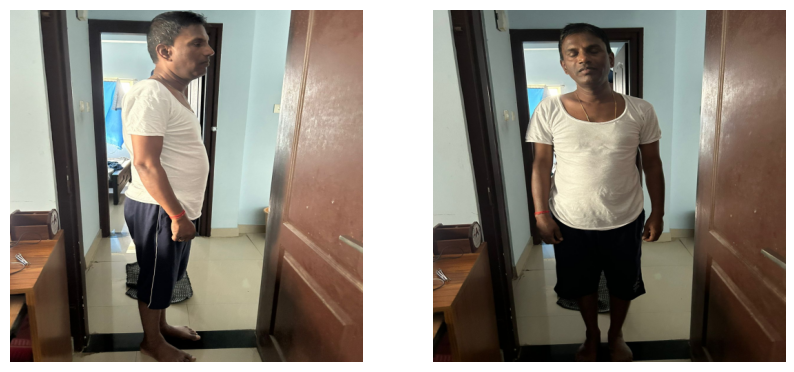

In [66]:
img0 = load_img(cfg.img0, size=cfg.size, interpolation=cfg.interpolation)
img1 = load_img(cfg.img1, size=cfg.size, interpolation=cfg.interpolation)

plot_two_imgs(img0, img1)

In [67]:
def preprocess_opencv(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img


def match_opencv(img0, img1, cfg):    
    # preprocess rgb images
    img0 = preprocess_opencv(img0)
    img1 = preprocess_opencv(img1)

    # extract local features
    extractor = cfg["extractor"]
    kp0, des0 = extractor.detectAndCompute(img0, None)
    kp1, des1 = extractor.detectAndCompute(img1, None)
    
    # match the features
    matcher = cv2.BFMatcher_create(normType=cfg["normType"], crossCheck=cfg["crossCheck"])
    matches = matcher.match(des0, des1)
    
    # extract point coordinates from keypoint objects
    src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    
    return {
        "src_pts": src_pts,
        "dst_pts": dst_pts,
        "matches": matches,
        "kp0": kp0,
        "kp1": kp1,
        "img0": img0,
        "img1": img1
    }
    

def visualize_opencv(src_pts, dst_pts, kp0, kp1, matches, img0, img1, cfg, title="OpenCV", **kwargs):   
    homography, mask = get_homography(src_pts, dst_pts, cfg["method"], cfg["ransacReprojThreshold"])
    matches_mask = mask.ravel().tolist()
    
    # visualize mapping
    h, w = img0.shape[:2]
    pts = np.float32([[0, 0],[0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, homography)
    vis_mapping = cv2.polylines(img1.copy(), [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    # visualize matches
    draw_params = dict(
        matchColor = (0, 255, 0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matches_mask, # draw only inliers
        flags = 2
    )
    vis_matches = cv2.drawMatches(img0, kp0, img1, kp1, matches, None, **draw_params)
    
    # plot visualizations
    plot_two_imgs(vis_mapping, vis_matches, title=title)
    
    return homography

CPU times: user 1.05 s, sys: 206 ms, total: 1.26 s
Wall time: 391 ms


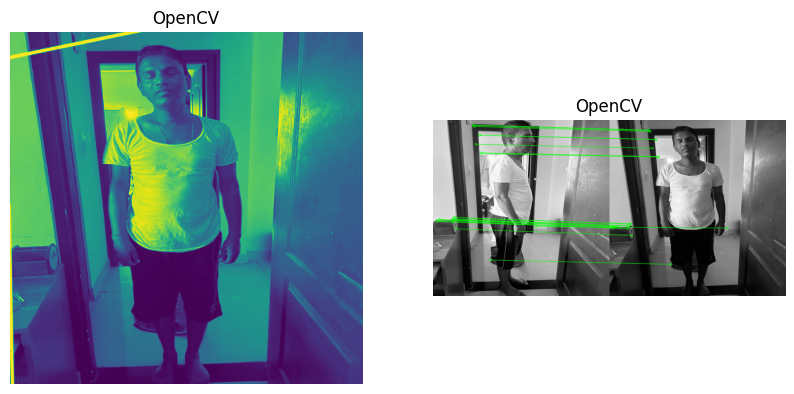

In [68]:
# OpenCV
%time results_opencv = match_opencv(img0, img1, cfg.opencv)
homography_opencv = visualize_opencv(**results_opencv, cfg=cfg.opencv["homography"], title="OpenCV")

In [69]:
def preprocess_lightglue(img):
    img = numpy_image_to_torch(img)
    return img


def match_lightglue(img0, img1, cfg):
    img0 = preprocess_lightglue(img0)
    img1 = preprocess_lightglue(img1)
    
    if cfg["extractor"] == "SuperPoint":
        extractor = SuperPoint(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])
        matcher = LightGlue(features='superpoint').eval().to(cfg["device"])

    if cfg["extractor"] == "DISK":
        extractor = DISK(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])  # load the extractor
        matcher = LightGlue(features='disk').eval().to(cfg["device"])  # load the matcher

    # extract local features
    feats0 = extractor.extract(img0)  # auto-resize the image, disable with resize=None
    feats1 = extractor.extract(img1)
    
    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
    
    # get results
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = kpts0[matches[..., 0]]  # coordinates in img0, shape (K,2)
    points1 = kpts1[matches[..., 1]]  # coordinates in img1, shape (K,2)
        
    return {
        "points0": points0,
        "points1": points1,
        "matches01": matches01, 
        "matches": matches,
        "kpts0": kpts0,
        "kpts1": kpts1,
        "img0": img0,
        "img1": img1
    }


def visualize_lightglue(img0, img1, points0, points1, kpts0, kpts1, matches01, **kwargs):
    axes = viz2d.plot_images([img0, img1])
    viz2d.plot_matches(points0, points1, color='lime', lw=0.2)
    viz2d.add_text(0, f'After {matches01["stop"]} layers', fs=10)

    kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
    viz2d.plot_images([img0, img1])
    viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

CPU times: user 10.6 s, sys: 2.27 s, total: 12.8 s
Wall time: 7.43 s


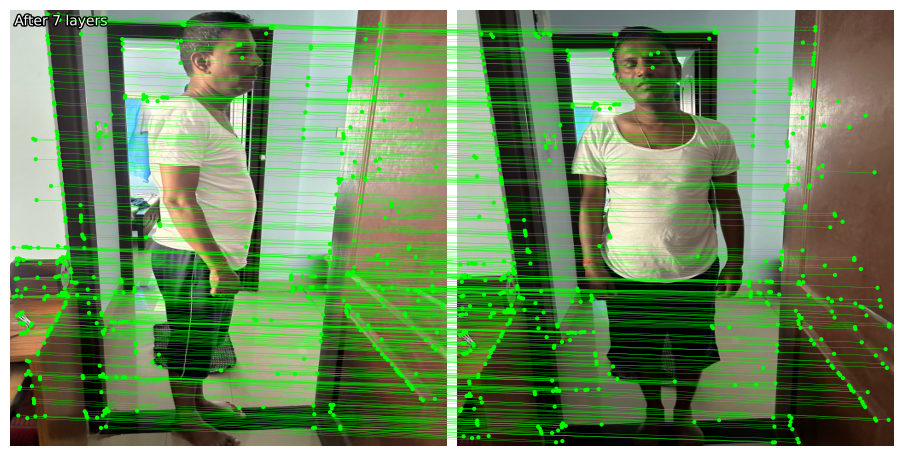

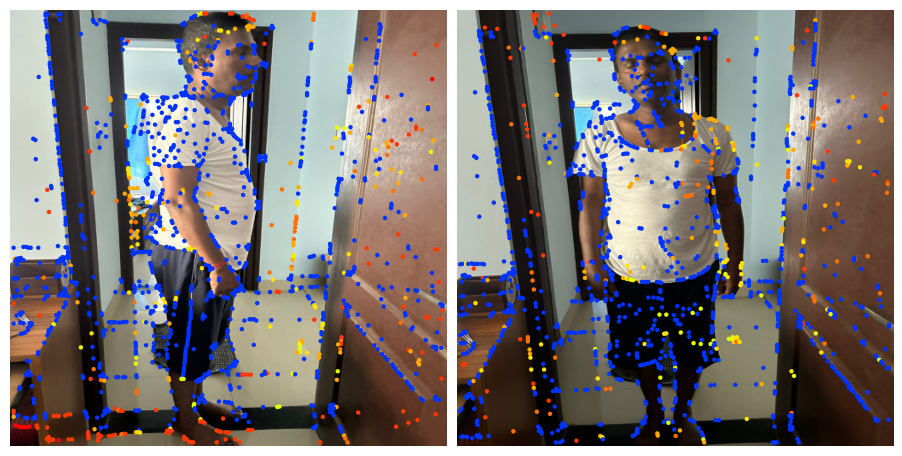

In [70]:
# LightGlue
%time results_lightglue = match_lightglue(img0, img1, cfg.lightglue)
visualize_lightglue(**results_lightglue)

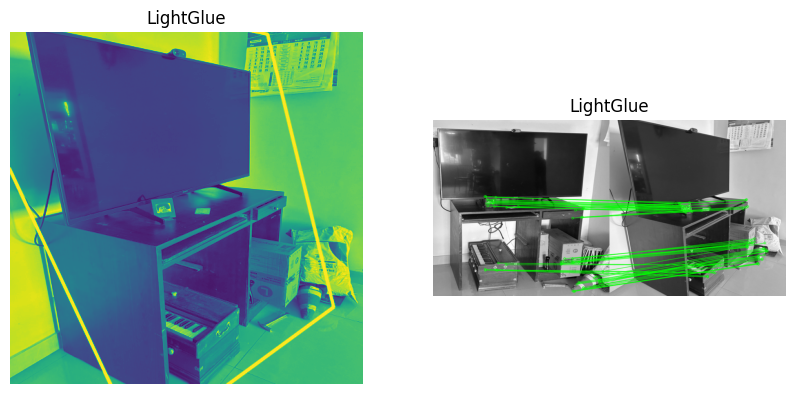

In [42]:
# Visualize LightGlue results with OpenCV tools
def lightglue2opencv(points0, points1, matches, kpts0, kpts1, img0, img1, **kwargs):
    return {
        "src_pts": points0.numpy().reshape(-1, 1, 2),
        "dst_pts": points1.numpy().reshape(-1, 1, 2),
        "kp0": cv2.KeyPoint_convert(kpts0.numpy()),
        "kp1": cv2.KeyPoint_convert(kpts1.numpy()),
        "matches": tuple(
            cv2.DMatch(matches[i][0].item(), matches[i][1].item(), 0.) 
            for i in range(matches.shape[0])
        ),
        "img0": cv2.cvtColor((255 * img0).numpy().astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2GRAY),
        "img1": cv2.cvtColor((255 * img1).numpy().astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2GRAY)
    }


results_lightglue_opencv = lightglue2opencv(**results_lightglue)
homography_lightglue = visualize_opencv(**results_lightglue_opencv, cfg=cfg.lightglue["homography"], title="LightGlue")

In [12]:
print("Lightglue:\n", homography_lightglue.round(2))
print("OpenCV:\n", homography_opencv.round(2))

Lightglue:
 [[   1.77    0.83 -143.34]
 [   0.22    1.96 -103.78]
 [   0.      0.      1.  ]]
OpenCV:
 [[-0.0000e+00 -1.4100e+00  4.9409e+02]
 [ 1.3000e-01 -1.4200e+00  4.6368e+02]
 [ 0.0000e+00 -0.0000e+00  1.0000e+00]]


In [43]:
class cfg:
    img0 = "/kaggle/working/Light_glue/WhatsApp Image 2024-07-13 at 13.46.50_2bb7fa9b.jpg"
    img1 = "/kaggle/working/Light_glue/WhatsApp Image 2024-07-13 at 13.47.01_3598ad53.jpg"
    
    size = (512, 512)
    interpolation = cv2.INTER_AREA
    
    opencv = {
        "extractor": cv2.KAZE_create(),
        "normType": cv2.NORM_L2,
        "crossCheck": True, 
        "homography": {
            "method": cv2.RANSAC,
            "ransacReprojThreshold": 3.0
        }
    }
    
    lightglue = {
        "extractor": "SuperPoint", # SuperPoint, DISK
        "device": "cpu", # cpu, cuda
        "max_kpts": 2048,
        "homography": {
            "method": cv2.RANSAC,
            "ransacReprojThreshold": 3.0
        }
    }

In [44]:
def load_img(file, size, interpolation):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=interpolation)
    return img


def get_homography(src_pts, dst_pts, method, ransacReprojThreshold):
    homography, mask = cv2.findHomography(
        src_pts, 
        dst_pts, 
        method=method, 
        ransacReprojThreshold=ransacReprojThreshold
    )
    return homography, mask


def plot_two_imgs(img0, img1, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img0)
    axes[0].axis("off")
    axes[0].set_title(title)
    axes[1].imshow(img1)
    axes[1].axis("off")
    axes[1].set_title(title)
    plt.show()

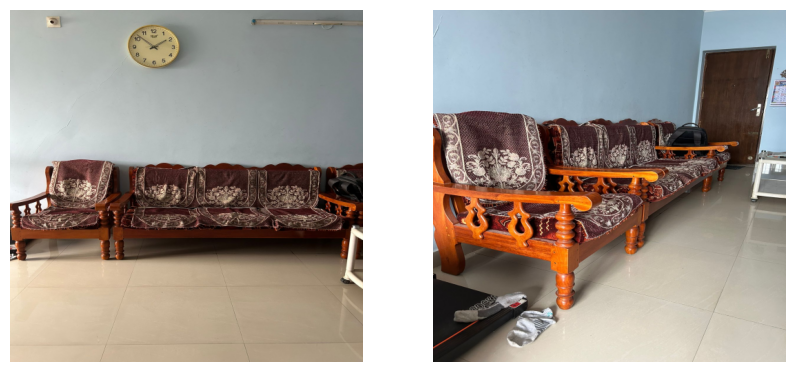

In [45]:
img0 = load_img(cfg.img0, size=cfg.size, interpolation=cfg.interpolation)
img1 = load_img(cfg.img1, size=cfg.size, interpolation=cfg.interpolation)

plot_two_imgs(img0, img1)

In [46]:
def preprocess_opencv(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img


def match_opencv(img0, img1, cfg):    
    # preprocess rgb images
    img0 = preprocess_opencv(img0)
    img1 = preprocess_opencv(img1)

    # extract local features
    extractor = cfg["extractor"]
    kp0, des0 = extractor.detectAndCompute(img0, None)
    kp1, des1 = extractor.detectAndCompute(img1, None)
    
    # match the features
    matcher = cv2.BFMatcher_create(normType=cfg["normType"], crossCheck=cfg["crossCheck"])
    matches = matcher.match(des0, des1)
    
    # extract point coordinates from keypoint objects
    src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    
    return {
        "src_pts": src_pts,
        "dst_pts": dst_pts,
        "matches": matches,
        "kp0": kp0,
        "kp1": kp1,
        "img0": img0,
        "img1": img1
    }
    

def visualize_opencv(src_pts, dst_pts, kp0, kp1, matches, img0, img1, cfg, title="OpenCV", **kwargs):   
    homography, mask = get_homography(src_pts, dst_pts, cfg["method"], cfg["ransacReprojThreshold"])
    matches_mask = mask.ravel().tolist()
    
    # visualize mapping
    h, w = img0.shape[:2]
    pts = np.float32([[0, 0],[0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, homography)
    vis_mapping = cv2.polylines(img1.copy(), [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    # visualize matches
    draw_params = dict(
        matchColor = (0, 255, 0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matches_mask, # draw only inliers
        flags = 2
    )
    vis_matches = cv2.drawMatches(img0, kp0, img1, kp1, matches, None, **draw_params)
    
    # plot visualizations
    plot_two_imgs(vis_mapping, vis_matches, title=title)
    
    return homography

CPU times: user 1.19 s, sys: 187 ms, total: 1.37 s
Wall time: 453 ms


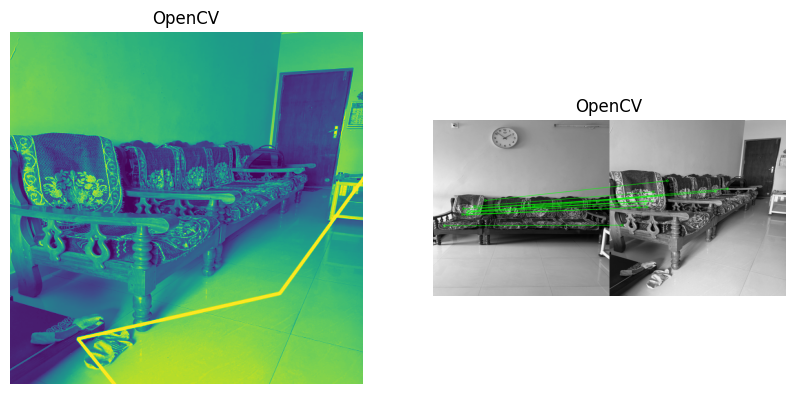

In [47]:
# OpenCV
%time results_opencv = match_opencv(img0, img1, cfg.opencv)
homography_opencv = visualize_opencv(**results_opencv, cfg=cfg.opencv["homography"], title="OpenCV")

In [48]:
def preprocess_lightglue(img):
    img = numpy_image_to_torch(img)
    return img


def match_lightglue(img0, img1, cfg):
    img0 = preprocess_lightglue(img0)
    img1 = preprocess_lightglue(img1)
    
    if cfg["extractor"] == "SuperPoint":
        extractor = SuperPoint(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])
        matcher = LightGlue(features='superpoint').eval().to(cfg["device"])

    if cfg["extractor"] == "DISK":
        extractor = DISK(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])  # load the extractor
        matcher = LightGlue(features='disk').eval().to(cfg["device"])  # load the matcher

    # extract local features
    feats0 = extractor.extract(img0)  # auto-resize the image, disable with resize=None
    feats1 = extractor.extract(img1)
    
    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
    
    # get results
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = kpts0[matches[..., 0]]  # coordinates in img0, shape (K,2)
    points1 = kpts1[matches[..., 1]]  # coordinates in img1, shape (K,2)
        
    return {
        "points0": points0,
        "points1": points1,
        "matches01": matches01, 
        "matches": matches,
        "kpts0": kpts0,
        "kpts1": kpts1,
        "img0": img0,
        "img1": img1
    }


def visualize_lightglue(img0, img1, points0, points1, kpts0, kpts1, matches01, save_path=None, **kwargs):
    # Plot images
    axes = viz2d.plot_images([img0, img1])
    
    # Plot matches
    viz2d.plot_matches(points0, points1, color='lime', lw=0.2)
    
    # Add text
    viz2d.add_text(0, f'After {matches01["stop"]} layers', fs=10)
    
    # Plot keypoints with pruning colors
    kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
    viz2d.plot_images([img0, img1])
    viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
    
    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path)

CPU times: user 11.5 s, sys: 2.34 s, total: 13.9 s
Wall time: 7.97 s


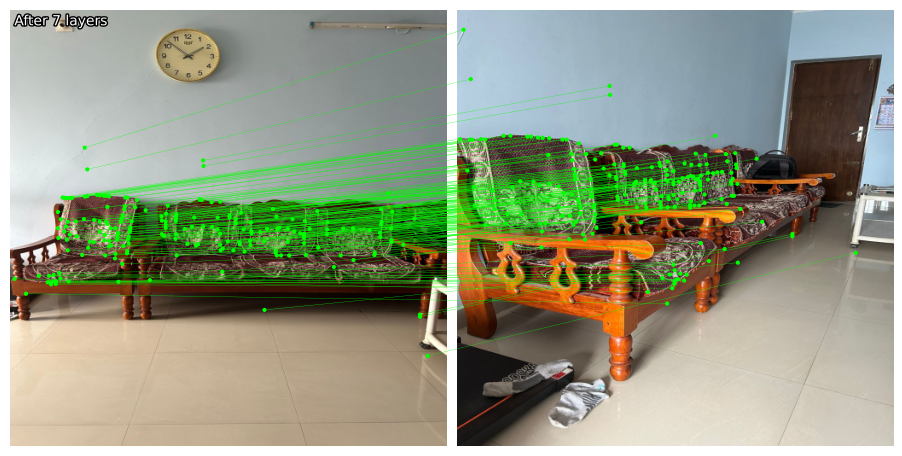

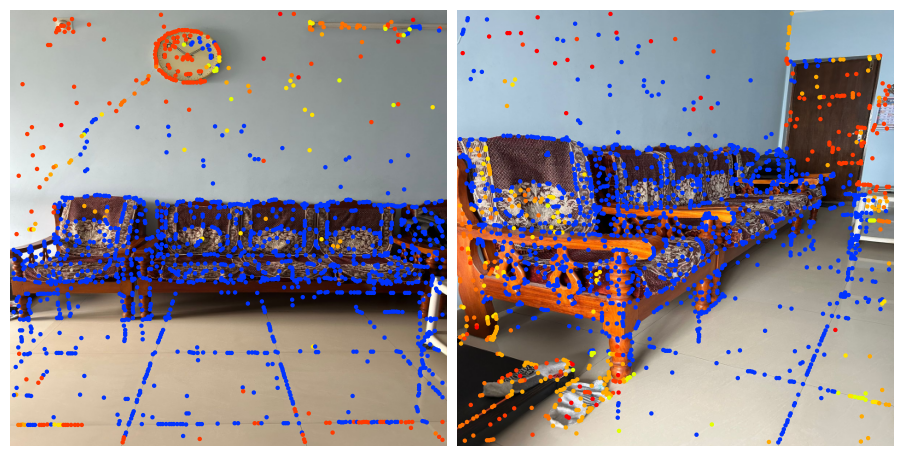

In [49]:
# LightGlue
%time results_lightglue = match_lightglue(img0, img1, cfg.lightglue)
visualize_lightglue(**results_lightglue)

In [50]:
class cfg:
    img0 = "/kaggle/working/Light_glue/WhatsApp Image 2024-07-13 at 13.46.47_d9c4479c.jpg"
    img1 = "/kaggle/working/Light_glue/WhatsApp Image 2024-07-13 at 13.47.06_2d2b4260.jpg"
    
    size = (512, 512)
    interpolation = cv2.INTER_AREA
    
    opencv = {
        "extractor": cv2.KAZE_create(),
        "normType": cv2.NORM_L2,
        "crossCheck": True, 
        "homography": {
            "method": cv2.RANSAC,
            "ransacReprojThreshold": 3.0
        }
    }
    
    lightglue = {
        "extractor": "SuperPoint", # SuperPoint, DISK
        "device": "cpu", # cpu, cuda
        "max_kpts": 2048,
        "homography": {
            "method": cv2.RANSAC,
            "ransacReprojThreshold": 3.0
        }
    }

In [51]:
def load_img(file, size, interpolation):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=interpolation)
    return img


def get_homography(src_pts, dst_pts, method, ransacReprojThreshold):
    homography, mask = cv2.findHomography(
        src_pts, 
        dst_pts, 
        method=method, 
        ransacReprojThreshold=ransacReprojThreshold
    )
    return homography, mask


def plot_two_imgs(img0, img1, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img0)
    axes[0].axis("off")
    axes[0].set_title(title)
    axes[1].imshow(img1)
    axes[1].axis("off")
    axes[1].set_title(title)
    plt.show()

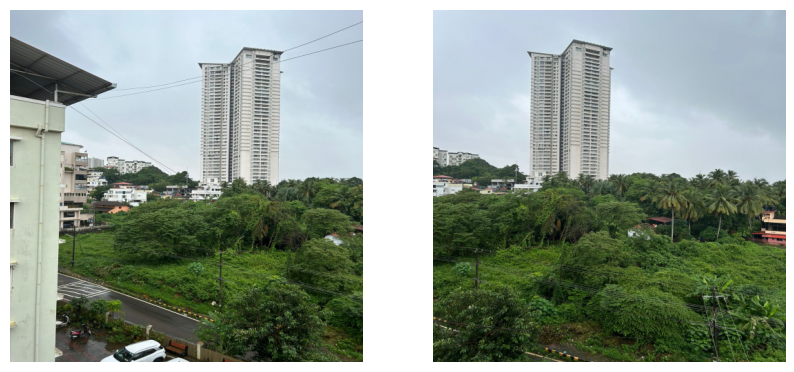

In [52]:
img0 = load_img(cfg.img0, size=cfg.size, interpolation=cfg.interpolation)
img1 = load_img(cfg.img1, size=cfg.size, interpolation=cfg.interpolation)

plot_two_imgs(img0, img1)

In [53]:
def preprocess_opencv(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img


def match_opencv(img0, img1, cfg):    
    # preprocess rgb images
    img0 = preprocess_opencv(img0)
    img1 = preprocess_opencv(img1)

    # extract local features
    extractor = cfg["extractor"]
    kp0, des0 = extractor.detectAndCompute(img0, None)
    kp1, des1 = extractor.detectAndCompute(img1, None)
    
    # match the features
    matcher = cv2.BFMatcher_create(normType=cfg["normType"], crossCheck=cfg["crossCheck"])
    matches = matcher.match(des0, des1)
    
    # extract point coordinates from keypoint objects
    src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    
    return {
        "src_pts": src_pts,
        "dst_pts": dst_pts,
        "matches": matches,
        "kp0": kp0,
        "kp1": kp1,
        "img0": img0,
        "img1": img1
    }
    

def visualize_opencv(src_pts, dst_pts, kp0, kp1, matches, img0, img1, cfg, title="OpenCV", **kwargs):   
    homography, mask = get_homography(src_pts, dst_pts, cfg["method"], cfg["ransacReprojThreshold"])
    matches_mask = mask.ravel().tolist()
    
    # visualize mapping
    h, w = img0.shape[:2]
    pts = np.float32([[0, 0],[0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, homography)
    vis_mapping = cv2.polylines(img1.copy(), [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    # visualize matches
    draw_params = dict(
        matchColor = (0, 255, 0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matches_mask, # draw only inliers
        flags = 2
    )
    vis_matches = cv2.drawMatches(img0, kp0, img1, kp1, matches, None, **draw_params)
    
    # plot visualizations
    plot_two_imgs(vis_mapping, vis_matches, title=title)
    
    return homography

CPU times: user 1.08 s, sys: 198 ms, total: 1.28 s
Wall time: 427 ms


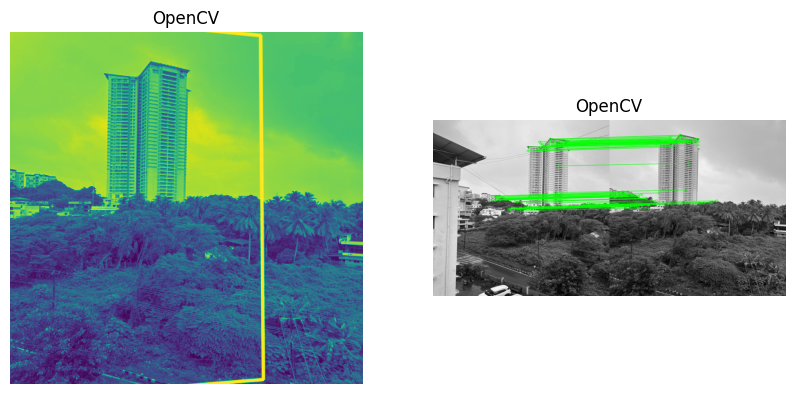

In [54]:
# OpenCV
%time results_opencv = match_opencv(img0, img1, cfg.opencv)
homography_opencv = visualize_opencv(**results_opencv, cfg=cfg.opencv["homography"], title="OpenCV")

In [56]:
def preprocess_lightglue(img):
    img = numpy_image_to_torch(img)
    return img


def match_lightglue(img0, img1, cfg):
    img0 = preprocess_lightglue(img0)
    img1 = preprocess_lightglue(img1)
    
    if cfg["extractor"] == "SuperPoint":
        extractor = SuperPoint(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])
        matcher = LightGlue(features='superpoint').eval().to(cfg["device"])

    if cfg["extractor"] == "DISK":
        extractor = DISK(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])  # load the extractor
        matcher = LightGlue(features='disk').eval().to(cfg["device"])  # load the matcher

    # extract local features
    feats0 = extractor.extract(img0)  # auto-resize the image, disable with resize=None
    feats1 = extractor.extract(img1)
    
    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
    
    # get results
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = kpts0[matches[..., 0]]  # coordinates in img0, shape (K,2)
    points1 = kpts1[matches[..., 1]]  # coordinates in img1, shape (K,2)
        
    return {
        "points0": points0,
        "points1": points1,
        "matches01": matches01, 
        "matches": matches,
        "kpts0": kpts0,
        "kpts1": kpts1,
        "img0": img0,
        "img1": img1
    }


def visualize_lightglue(img0, img1, points0, points1, kpts0, kpts1, matches01, save_path=None, **kwargs):
    # Plot images
    axes = viz2d.plot_images([img0, img1])
    
    # Plot matches
    viz2d.plot_matches(points0, points1, color='lime', lw=0.2)
    
    # Add text
    viz2d.add_text(0, f'After {matches01["stop"]} layers', fs=10)
    
    # Plot keypoints with pruning colors
    kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
    viz2d.plot_images([img0, img1])
    viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)
    
    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path)

CPU times: user 11 s, sys: 2.2 s, total: 13.2 s
Wall time: 7.71 s


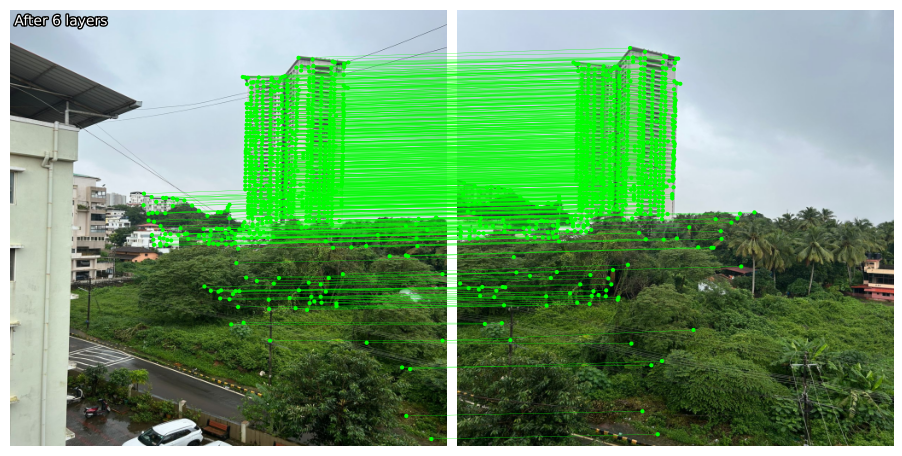

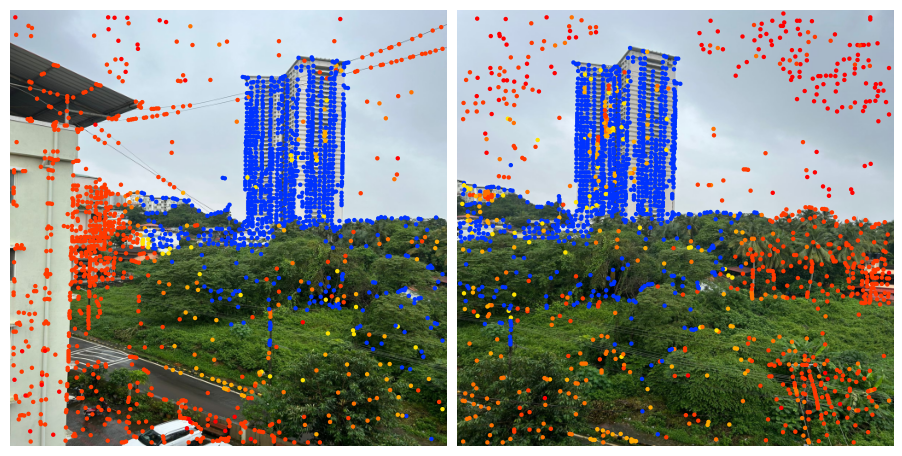

In [57]:
# LightGlue
%time results_lightglue = match_lightglue(img0, img1, cfg.lightglue)
visualize_lightglue(**results_lightglue)